# STDP

Quelle: https://compneuro.neuromatch.io/tutorials/W2D3_BiologicalNeuronModels/student/W2D3_Tutorial4.html

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format='retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

In [4]:
# @title Plotting functions
def my_raster_plot(range_t, spike_train, n):
  """Generates poisson trains

  Args:
    range_t     : time sequence
    spike_train : binary spike trains, with shape (N, Lt)
    n           : number of Poisson trains plot

  Returns:
    Raster_plot of the spike train
  """

  # Find the number of all the spike trains
  N = spike_train.shape[0]

  # n should be smaller than N:
  if n > N:
    print('The number n exceeds the size of spike trains')
    print('The number n is set to be the size of spike trains')
    n = N

  # Raster plot
  i = 0
  while i <= n:
    if spike_train[i, :].sum() > 0.:
      t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
      plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
    i += 1
  plt.xlim([range_t[0], range_t[-1]])
  plt.ylim([-0.5, n + 0.5])
  plt.xlabel('Time (ms)')
  plt.ylabel('Neuron ID')
  plt.show()


def my_example_P(pre_spike_train_ex, pars, P):
  """Generates two plots (raster plot and LTP vs time plot)

  Args:
    pre_spike_train_ex     : spike-train
    pars : dictionary with the parameters
    P : LTP ratio

  Returns:
    my_example_P returns a rastert plot (top),
    and a LTP ratio across time (bottom)
  """
  spT = pre_spike_train_ex
  plt.figure(figsize=(7, 6))
  plt.subplot(211)
  color_set = ['red', 'blue', 'black', 'orange', 'cyan']
  for i in range(spT.shape[0]):
    t_sp = pars['range_t'][spT[i, :] > 0.5]   # spike times
    plt.plot(t_sp, i*np.ones(len(t_sp)), '|',
             color=color_set[i],
             ms=10, markeredgewidth=2)
  plt.xlabel('Time (ms)')
  plt.ylabel('Neuron ID')
  plt.xlim(0, 200)

  plt.subplot(212)
  for k in range(5):
    plt.plot(pars['range_t'], P[k, :], color=color_set[k], lw=1.5)
  plt.xlabel('Time (ms)')
  plt.ylabel('P(t)')
  plt.xlim(0, 200)

  plt.tight_layout()
  plt.show()


def mySTDP_plot(A_plus, A_minus, tau_stdp, time_diff, dW):
  plt.figure()
  plt.plot([-5 * tau_stdp, 5 * tau_stdp], [0, 0], 'k', linestyle=':')
  plt.plot([0, 0], [-A_minus, A_plus], 'k', linestyle=':')

  plt.plot(time_diff[time_diff <= 0], dW[time_diff <= 0], 'ro')
  plt.plot(time_diff[time_diff > 0], dW[time_diff > 0], 'bo')

  plt.xlabel(r't$_{\mathrm{pre}}$ - t$_{\mathrm{post}}$ (ms)')
  plt.ylabel(r'$\Delta$W', fontsize=12)
  plt.title('Biphasic STDP', fontsize=12, fontweight='bold')
  plt.show()

In [ ]:
# @title Helper functions

def default_pars_STDP(**kwargs):
  pars = {}

  # typical neuron parameters
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['V_init'] = -65.   # initial potential [mV]
  pars['V_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  # STDP parameters
  pars['A_plus'] = 0.008                   # magnitude of LTP
  pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD
  pars['tau_stdp'] = 20.                   # STDP time constant [ms]

  # simulation parameters
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  # external parameters if any
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


def Poisson_generator(pars, rate, n, myseed=False):
  """Generates poisson trains

  Args:
    pars            : parameter dictionary
    rate            : noise amplitute [Hz]
    n               : number of Poisson trains
    myseed          : random seed. int or boolean

  Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  if myseed:
    np.random.seed(seed=myseed)
  else:
    np.random.seed()

  # generate uniformly distributed random variables
  u_rand = np.random.rand(n, Lt)

  # generate Poisson train
  poisson_train = 1. * (u_rand < rate * (dt / 1000.))

  return poisson_train

In [5]:
def Delta_W(pars, A_plus, A_minus, tau_stdp):
  """
  Plot STDP biphasic exponential decaying function

  Args:
    pars       : parameter dictionary
    A_plus     : (float) maximum amount of synaptic modification
                 which occurs when the timing difference between pre- and
                 post-synaptic spikes is positive
    A_minus    : (float) maximum amount of synaptic modification
                 which occurs when the timing difference between pre- and
                 post-synaptic spikes is negative
    tau_stdp   : the ranges of pre-to-postsynaptic interspike intervals
                 over which synaptic strengthening or weakening occurs

  Returns:
    dW         : instantaneous change in weights
  """

  # STDP change
  dW = np.zeros(len(time_diff))
  # Calculate dW for LTP
  dW[time_diff <= 0] = A_plus * np.exp(time_diff[time_diff <= 0] / tau_stdp)
  # Calculate dW for LTD
  dW[time_diff > 0] = -A_minus * np.exp(-time_diff[time_diff > 0] / tau_stdp)

  return dW


pars = default_pars_STDP()
# Get parameters
A_plus, A_minus, tau_stdp = pars['A_plus'], pars['A_minus'], pars['tau_stdp']
# pre_spike time - post_spike time
time_diff = np.linspace(-5 * tau_stdp, 5 * tau_stdp, 50)

dW = Delta_W(pars, A_plus, A_minus, tau_stdp)
with plt.xkcd():
  mySTDP_plot(A_plus, A_minus, tau_stdp, time_diff, dW)

NameError: name 'default_pars_STDP' is not defined

In [6]:
def generate_P(pars, pre_spike_train_ex):
  """
  track of pre-synaptic spikes

  Args:
    pars               : parameter dictionary
    pre_spike_train_ex : binary spike train input from
                         presynaptic excitatory neuron

  Returns:
    P                  : LTP ratio
  """

  # Get parameters
  A_plus, tau_stdp = pars['A_plus'], pars['tau_stdp']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Initialize
  P = np.zeros(pre_spike_train_ex.shape)
  for it in range(Lt - 1):
    # Calculate the delta increment dP
    dP = -(dt / tau_stdp) * P[:, it] + A_plus * pre_spike_train_ex[:, it + 1]
    # Update P
    P[:, it + 1] = P[:, it] + dP

  return P


pars = default_pars_STDP(T=200., dt=1.)
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=5, myseed=2020)
P = generate_P(pars, pre_spike_train_ex)
with plt.xkcd():
  my_example_P(pre_spike_train_ex, pars, P)

NameError: name 'default_pars_STDP' is not defined

## Lava STDP

Quelle: https://lava-nc.org/lava/notebooks/in_depth/tutorial08_stdp.html

In [10]:
!pip install lava-nc

ERROR: Ignored the following versions that require a different python version: 0.10.0 Requires-Python <3.11,>=3.10; 0.7.0 Requires-Python >=3.8,<3.11; 0.7.0.post1 Requires-Python >=3.8,<3.11; 0.7.0.post2 Requires-Python >=3.8,<3.11; 0.8.0 Requires-Python >=3.8,<3.11; 0.9.0 Requires-Python >=3.8,<3.11
ERROR: Could not find a version that satisfies the requirement lava-nc (from versions: none)
ERROR: No matching distribution found for lava-nc


In [11]:
import lava
from lava.proc.learning_rules.stdp_learning_rule import STDPLoihi


In [12]:
import numpy as np

# Set this tag to "fixed_pt" or "floating_pt" to choose the corresponding models.
SELECT_TAG = "floating_pt"

# LIF parameters
if SELECT_TAG == "fixed_pt":
    du = 4095
    dv = 4095
elif SELECT_TAG == "floating_pt":
    du = 1
    dv = 1
vth = 240

# Number of neurons per layer
num_neurons = 1
shape_lif = (num_neurons, )
shape_conn = (num_neurons, num_neurons)

# Connection parameters

# SpikePattern -> LIF connection weight
wgt_inp = np.eye(num_neurons) * 250

# LIF -> LIF connection initial weight (learning-enabled)
wgt_plast_conn = np.full(shape_conn, 50)

# Number of simulation time steps
num_steps = 200
time = list(range(1, num_steps + 1))

# Spike times
spike_prob = 0.03

# Create spike rasters
np.random.seed(123)
spike_raster_pre = np.zeros((num_neurons, num_steps))
np.place(spike_raster_pre, np.random.rand(num_neurons, num_steps) < spike_prob, 1)

spike_raster_post = np.zeros((num_neurons, num_steps))
np.place(spike_raster_post, np.random.rand(num_neurons, num_steps) < spike_prob, 1)

In [13]:
stdp = STDPLoihi(learning_rate=1,
                 A_plus=1,
                 A_minus=-1,
                 tau_plus=10,
                 tau_minus=10,
                 t_epoch=4)

In [14]:
from lava.proc.lif.process import LIF
from lava.proc.io.source import RingBuffer
from lava.proc.dense.process import LearningDense, Dense

In [15]:
# Create input devices
pattern_pre = RingBuffer(data=spike_raster_pre.astype(int))
pattern_post = RingBuffer(data=spike_raster_post.astype(int))

# Create input connectivity
conn_inp_pre = Dense(weights=wgt_inp)
conn_inp_post = Dense(weights=wgt_inp)

# Create pre-synaptic neurons
lif_pre = LIF(u=0,
              v=0,
              du=du,
              dv=dv,
              bias_mant=0,
              bias_exp=0,
              vth=vth,
              shape=shape_lif,
              name='lif_pre')

# Create plastic connection
plast_conn = LearningDense(weights=wgt_plast_conn,
                           learning_rule=stdp,
                           name='plastic_dense')

# Create post-synaptic neuron
lif_post = LIF(u=0,
               v=0,
               du=du,
               dv=dv,
               bias_mant=0,
               bias_exp=0,
               vth=vth,
               shape=shape_lif,
               name='lif_post')

# Connect network
pattern_pre.s_out.connect(conn_inp_pre.s_in)
conn_inp_pre.a_out.connect(lif_pre.a_in)

pattern_post.s_out.connect(conn_inp_post.s_in)
conn_inp_post.a_out.connect(lif_post.a_in)

lif_pre.s_out.connect(plast_conn.s_in)
plast_conn.a_out.connect(lif_post.a_in)

# Connect back-propagating action potential (BAP)
lif_post.s_out.connect(plast_conn.s_in_bap)

In [16]:
from lava.proc.monitor.process import Monitor


In [17]:
# Create monitors
mon_pre_trace = Monitor()
mon_post_trace = Monitor()
mon_pre_spikes = Monitor()
mon_post_spikes = Monitor()
mon_weight = Monitor()

# Connect monitors
mon_pre_trace.probe(plast_conn.x1, num_steps)
mon_post_trace.probe(plast_conn.y1, num_steps)
mon_pre_spikes.probe(lif_pre.s_out, num_steps)
mon_post_spikes.probe(lif_post.s_out, num_steps)
mon_weight.probe(plast_conn.weights, num_steps)

In [18]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

In [19]:
# Running
pattern_pre.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi2SimCfg(select_tag=SELECT_TAG))

In [20]:
# Get data from monitors
pre_trace = mon_pre_trace.get_data()['plastic_dense']['x1']
post_trace = mon_post_trace.get_data()['plastic_dense']['y1']
pre_spikes = mon_pre_spikes.get_data()['lif_pre']['s_out']
post_spikes = mon_post_spikes.get_data()['lif_post']['s_out']
weights = mon_weight.get_data()['plastic_dense']['weights'][:, :, 0]

In [21]:
# Stopping
pattern_pre.stop()

In [22]:
import matplotlib.pyplot as plt

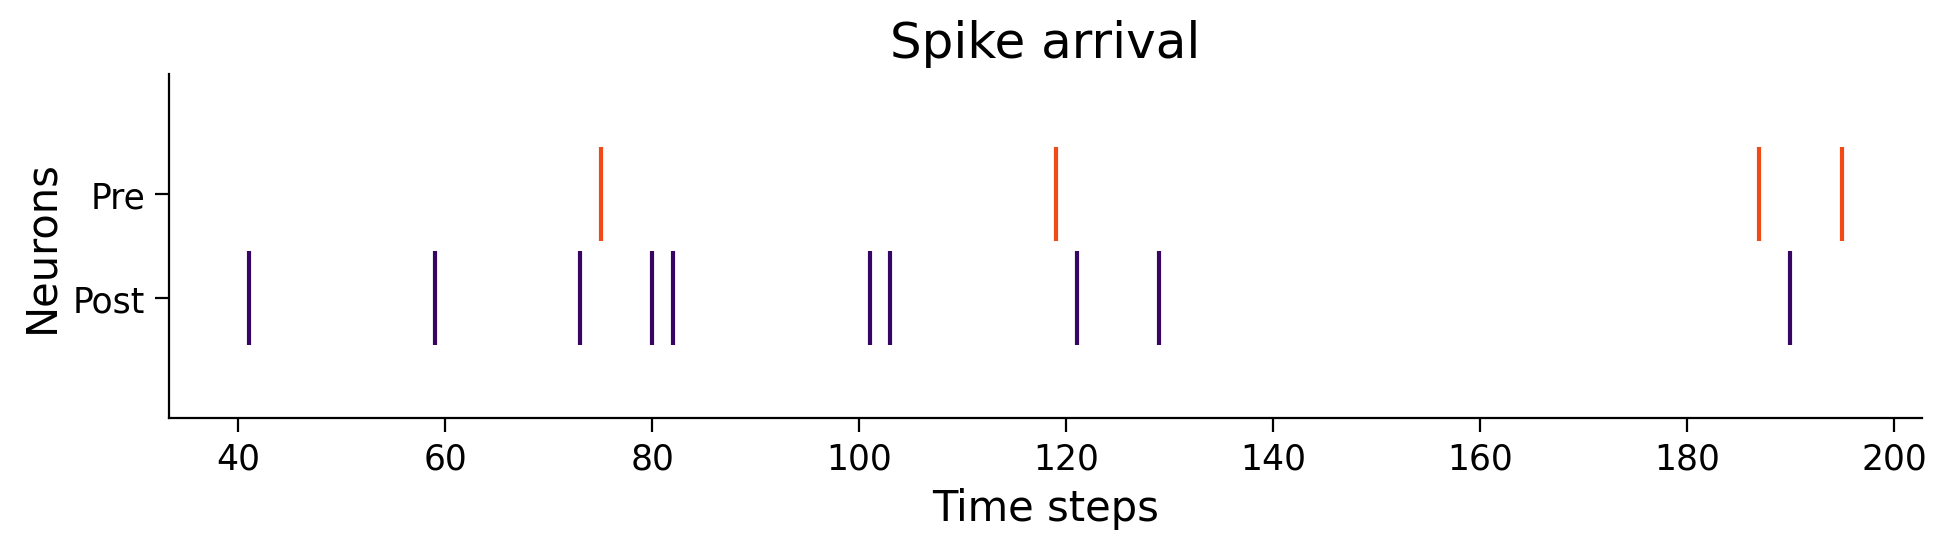

In [23]:
# Plotting pre- and post- spike arrival
def plot_spikes(spikes, legend, colors):
    offsets = list(range(1, len(spikes) + 1))

    plt.figure(figsize=(10, 3))

    spikes_plot = plt.eventplot(positions=spikes,
                                lineoffsets=offsets,
                                linelength=0.9,
                                colors=colors)

    plt.title("Spike arrival")
    plt.xlabel("Time steps")
    plt.ylabel("Neurons")
    plt.yticks(ticks=offsets, labels=legend)

    plt.show()

# Plot spikes
plot_spikes(spikes=[np.where(post_spikes[:, 0])[0], np.where(pre_spikes[:, 0])[0]],
            legend=['Post', 'Pre'],
            colors=['#370665', '#f14a16'])

/opt/conda/envs/lava_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


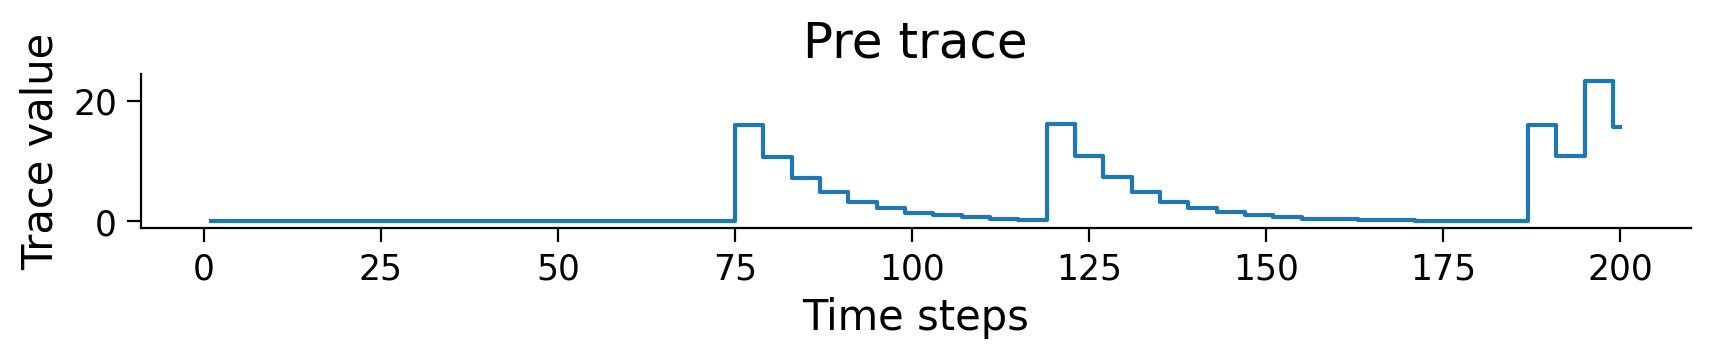

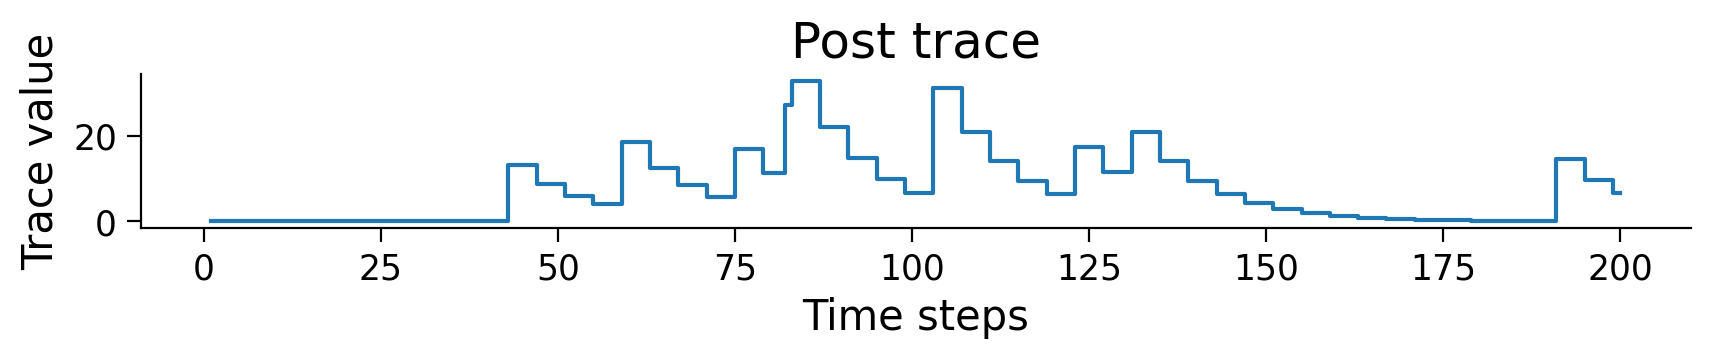

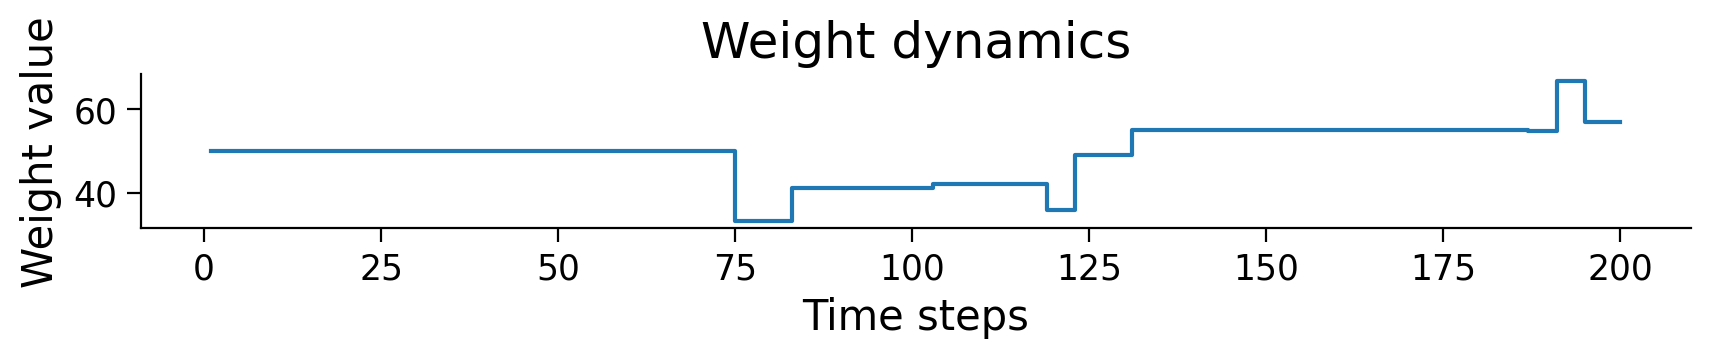

In [24]:
# Plotting trace dynamics

def plot_time_series(time, time_series, ylabel, title):
    plt.figure(figsize=(10, 1))

    plt.step(time, time_series)

    plt.title(title)
    plt.xlabel("Time steps")
    plt.ylabel(ylabel)

    plt.show()

# Plotting pre trace dynamics
plot_time_series(time=time, time_series=pre_trace, ylabel="Trace value", title="Pre trace")
# Plotting post trace dynamics
plot_time_series(time=time, time_series=post_trace, ylabel="Trace value", title="Post trace")
# Plotting weight dynamics
plot_time_series(time=time, time_series=weights, ylabel="Weight value", title="Weight dynamics")

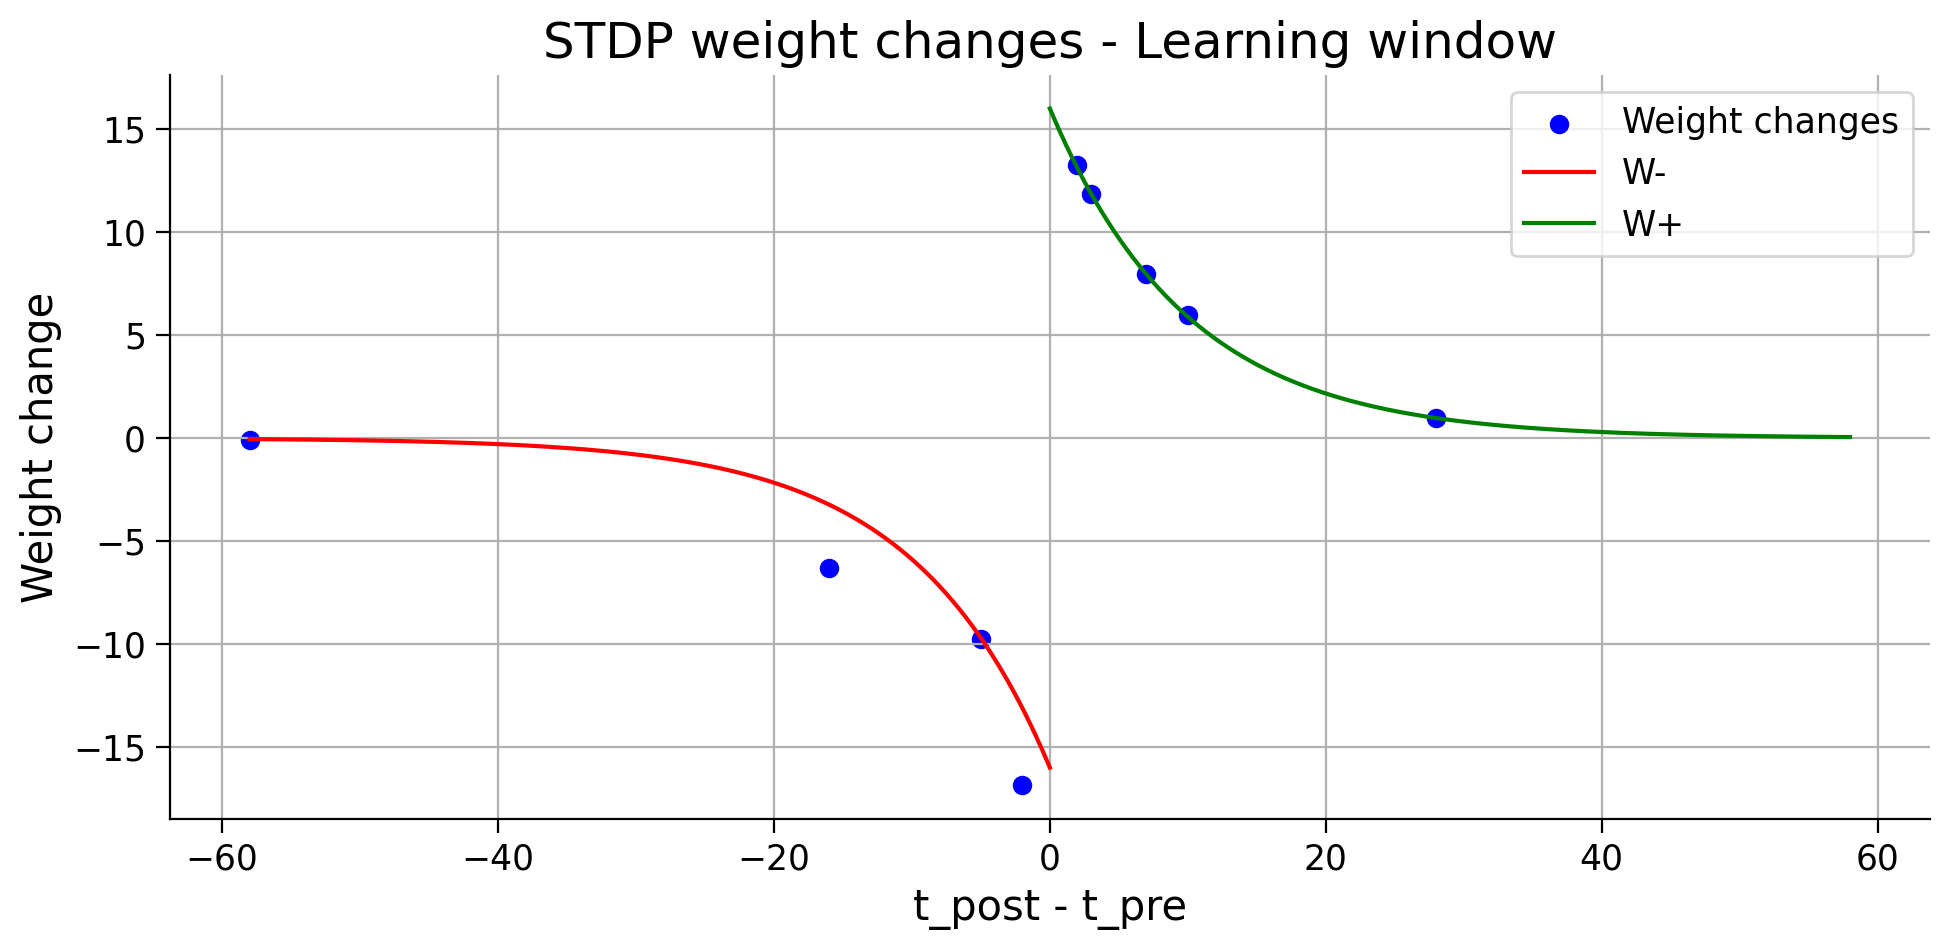

In [25]:
def extract_stdp_weight_changes(time, spikes_pre, spikes_post, wgt):
    # Compute the weight changes for every weight change event
    w_diff = np.zeros(wgt.shape)
    w_diff[1:] = np.diff(wgt)

    w_diff_non_zero = np.where(w_diff != 0)
    dw = w_diff[w_diff_non_zero].tolist()

    # Find the absolute time of every weight change event
    time = np.array(time)
    t_non_zero = time[w_diff_non_zero]

    # Compute the difference between post and pre synaptic spike time for every weight change event
    spikes_pre = np.array(spikes_pre)
    spikes_post = np.array(spikes_post)
    dt = []
    for i in range(0, len(dw)):
        time_stamp = t_non_zero[i]
        t_post = (spikes_post[np.where(spikes_post <= time_stamp)])[-1]
        t_pre = (spikes_pre[np.where(spikes_pre <= time_stamp)])[-1]
        dt.append(t_post-t_pre)

    return np.array(dt), np.array(dw)

def plot_stdp(time, spikes_pre, spikes_post, wgt,
              on_pre_stdp, y1_impulse, y1_tau,
              on_post_stdp, x1_impulse, x1_tau):
    # Derive weight changes as a function of time differences
    diff_t, diff_w = extract_stdp_weight_changes(time, spikes_pre, spikes_post, wgt)

    # Derive learning rule coefficients
    on_pre_stdp = eval(str(on_pre_stdp).replace("^", "**"))
    a_neg = on_pre_stdp * y1_impulse
    on_post_stdp = eval(str(on_post_stdp).replace("^", "**"))
    a_pos = on_post_stdp * x1_impulse

    # Derive x-axis limit (absolute value)
    max_abs_dt = np.maximum(np.abs(np.max(diff_t)), np.abs(np.min(diff_t)))

    # Derive x-axis for learning window computation (negative part)
    x_neg = np.linspace(-max_abs_dt, 0, 1000)
    # Derive learning window (negative part)
    w_neg = a_neg * np.exp(x_neg / y1_tau)

    # Derive x-axis for learning window computation (positive part)
    x_pos = np.linspace(0, max_abs_dt, 1000)
    # Derive learning window (positive part)
    w_pos = a_pos * np.exp(- x_pos / x1_tau)

    plt.figure(figsize=(10, 5))

    plt.scatter(diff_t, diff_w, label="Weight changes", color="b")

    plt.plot(x_neg, w_neg, label="W-", color="r")
    plt.plot(x_pos, w_pos, label="W+", color="g")

    plt.title("STDP weight changes - Learning window")
    plt.xlabel('t_post - t_pre')
    plt.ylabel('Weight change')
    plt.legend()
    plt.grid()

    plt.show()

# Plot STDP window
plot_stdp(time, np.where(pre_spikes[:, 0]), np.where(post_spikes[:, 0]), weights[:, 0],
          stdp.A_minus, stdp.y1_impulse, stdp.tau_minus,
          stdp.A_plus, stdp.x1_impulse, stdp.tau_plus)

## Eigene Lernregeln

Quelle: https://lava-nc.org/lava/notebooks/in_depth/tutorial09_custom_learning_rules.html

In [26]:
from lava.magma.core.learning.learning_rule import Loihi2FLearningRule

# Learning rule coefficient
on_pre_stdp = -2
on_post_stdp = 2

learning_rate = 1

# Trace decay constants
x1_tau = 10
y1_tau = 10

# Impulses
x1_impulse = 16
y1_impulse = 16

# Epoch length
t_epoch = 2

# Define dw as string
dw = f"{learning_rate} * ({on_pre_stdp}) * x0 * y1 +" \
     f"{learning_rate} * {on_post_stdp} * y0 * x1"

In [27]:
# Create custom LearningRule
stdp = Loihi2FLearningRule(dw=dw,
                           x1_impulse=x1_impulse,
                           x1_tau=x1_tau,
                           y1_impulse=y1_impulse,
                           y1_tau=y1_tau,
                           t_epoch=t_epoch)

In [28]:
import numpy as np

# Set this tag to "fixed_pt" or "floating_pt" to choose the corresponding models.
SELECT_TAG = "fixed_pt"

# LIF parameters
if SELECT_TAG == "fixed_pt":
    du = 4095
    dv = 4095
elif SELECT_TAG == "floating_pt":
    du = 1
    dv = 1
vth = 240

# Number of neurons per layer
num_neurons = 1
shape_lif = (num_neurons, )
shape_conn = (num_neurons, num_neurons)

# Connection parameters

# SpikePattern -> LIF connection weight
wgt_inp = np.eye(num_neurons) * 250

# LIF -> LIF connection initial weight (learning-enabled)
wgt_plast_conn = np.full(shape_conn, 50)

# Number of simulation time steps
num_steps = 200
time = list(range(1, num_steps + 1))

# Spike times
spike_prob = 0.03

# Create spike rasters
np.random.seed(123)
spike_raster_pre = np.zeros((num_neurons, num_steps))
np.place(spike_raster_pre, np.random.rand(num_neurons, num_steps) < spike_prob, 1)

spike_raster_post = np.zeros((num_neurons, num_steps))
np.place(spike_raster_post, np.random.rand(num_neurons, num_steps) < spike_prob, 1)

In [29]:
from lava.proc.lif.process import LIF
from lava.proc.io.source import RingBuffer
from lava.proc.dense.process import LearningDense, Dense

In [30]:
# Create input devices
pattern_pre = RingBuffer(data=spike_raster_pre.astype(int))
pattern_post = RingBuffer(data=spike_raster_post.astype(int))

# Create input connectivity
conn_inp_pre = Dense(weights=wgt_inp)
conn_inp_post = Dense(weights=wgt_inp)

# Create pre-synaptic neurons
lif_pre = LIF(u=0,
              v=0,
              du=du,
              dv=du,
              bias_mant=0,
              bias_exp=0,
              vth=vth,
              shape=shape_lif,
              name='lif_pre')

# Create plastic connection
plast_conn = LearningDense(weights=wgt_plast_conn,
                           learning_rule=stdp,
                           name='plastic_dense')

# Create post-synaptic neuron
lif_post = LIF(u=0,
               v=0,
               du=du,
               dv=du,
               bias_mant=0,
               bias_exp=0,
               vth=vth,
               shape=shape_lif,
               name='lif_post')

# Connect network
pattern_pre.s_out.connect(conn_inp_pre.s_in)
conn_inp_pre.a_out.connect(lif_pre.a_in)

pattern_post.s_out.connect(conn_inp_post.s_in)
conn_inp_post.a_out.connect(lif_post.a_in)

lif_pre.s_out.connect(plast_conn.s_in)
plast_conn.a_out.connect(lif_post.a_in)

# Connect back-propagating actionpotential (BAP)
lif_post.s_out.connect(plast_conn.s_in_bap)

In [31]:
from lava.proc.monitor.process import Monitor

In [32]:
# Create monitors
mon_pre_trace = Monitor()
mon_post_trace = Monitor()
mon_pre_spikes = Monitor()
mon_post_spikes = Monitor()
mon_weight = Monitor()

# Connect monitors
mon_pre_trace.probe(plast_conn.x1, num_steps)
mon_post_trace.probe(plast_conn.y1, num_steps)
mon_pre_spikes.probe(lif_pre.s_out, num_steps)
mon_post_spikes.probe(lif_post.s_out, num_steps)
mon_weight.probe(plast_conn.weights, num_steps)

In [33]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

In [34]:
pattern_pre.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi2SimCfg(select_tag=SELECT_TAG))


In [35]:
# Get data from monitors
pre_trace = mon_pre_trace.get_data()['plastic_dense']['x1']
post_trace = mon_post_trace.get_data()['plastic_dense']['y1']
pre_spikes = mon_pre_spikes.get_data()['lif_pre']['s_out']
post_spikes = mon_post_spikes.get_data()['lif_post']['s_out']
weights = mon_weight.get_data()['plastic_dense']['weights'][:, :, 0]

In [36]:
pattern_pre.stop()

In [37]:
import matplotlib.pyplot as plt


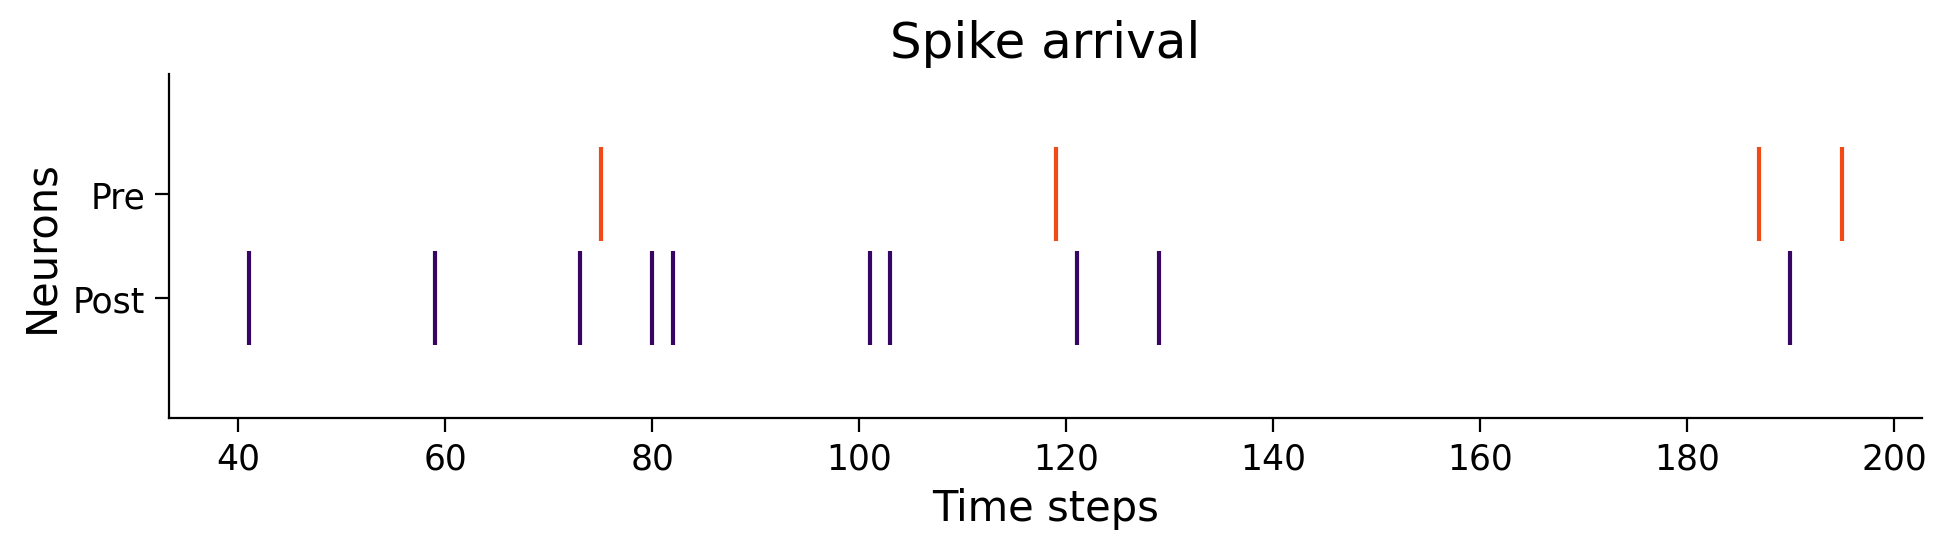

In [38]:
# Plotting pre- and post- spike arrival
def plot_spikes(spikes, legend, colors):
    offsets = list(range(1, len(spikes) + 1))

    plt.figure(figsize=(10, 3))

    spikes_plot = plt.eventplot(positions=spikes,
                                lineoffsets=offsets,
                                linelength=0.9,
                                colors=colors)

    plt.title("Spike arrival")
    plt.xlabel("Time steps")
    plt.ylabel("Neurons")
    plt.yticks(ticks=offsets, labels=legend)

    plt.show()

# Plot spikes
plot_spikes(spikes=[np.where(post_spikes[:, 0])[0], np.where(pre_spikes[:, 0])[0]],
            legend=['Post', 'Pre'],
            colors=['#370665', '#f14a16'])

/opt/conda/envs/lava_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


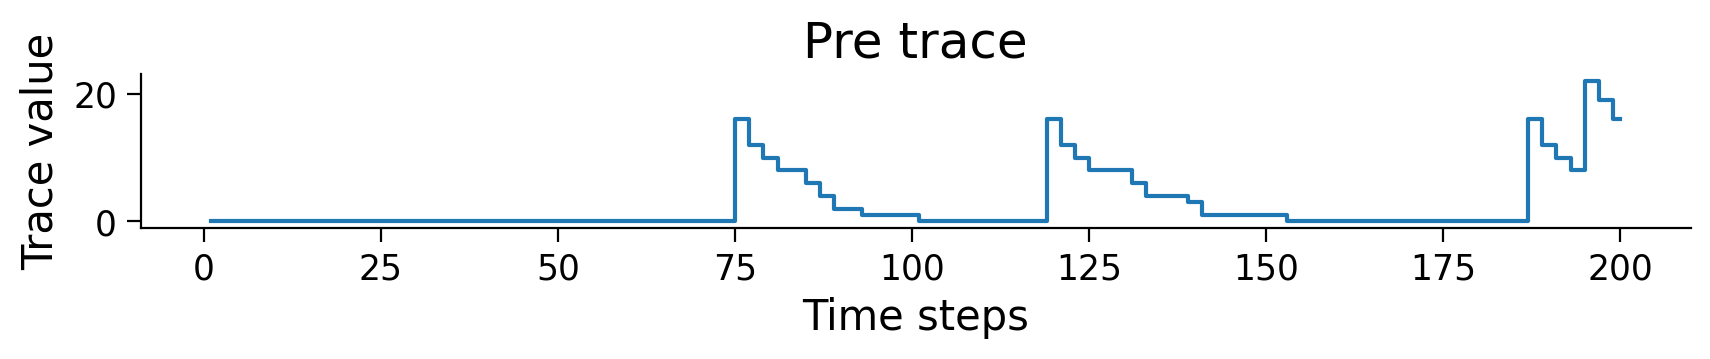

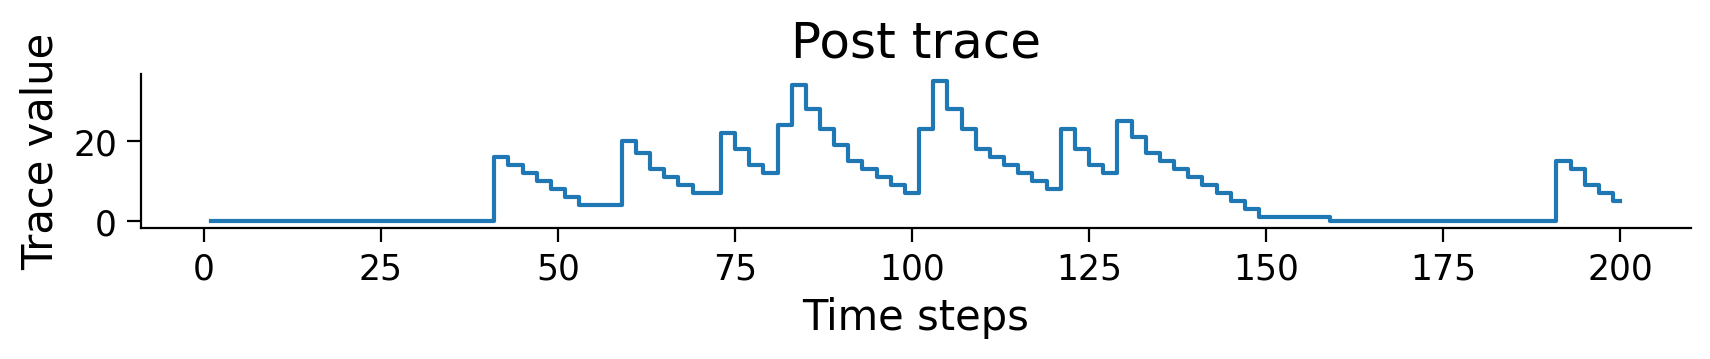

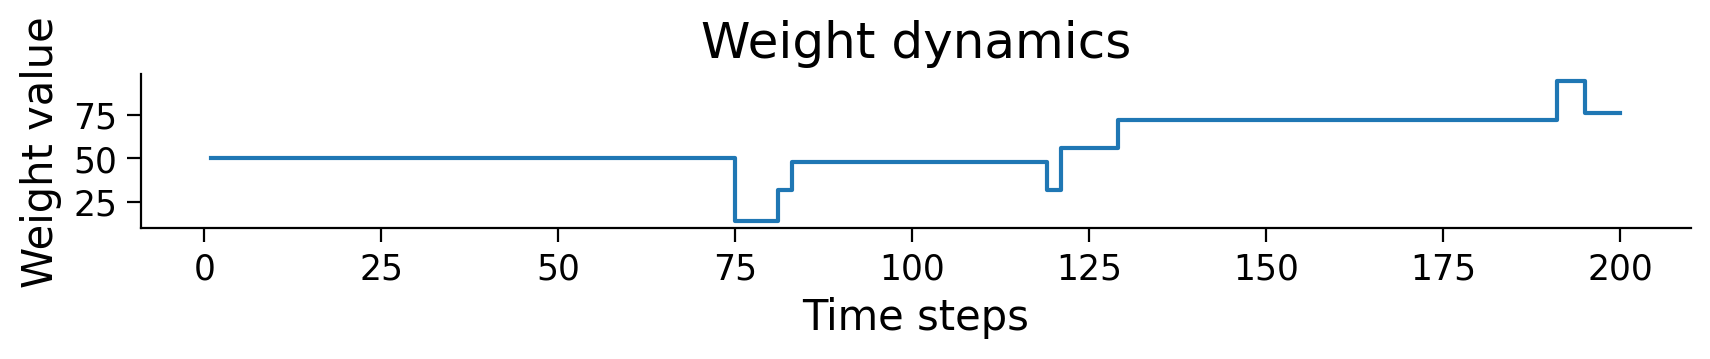

In [39]:
# Plotting trace dynamics

def plot_time_series(time, time_series, ylabel, title):
    plt.figure(figsize=(10, 1))

    plt.step(time, time_series)

    plt.title(title)
    plt.xlabel("Time steps")
    plt.ylabel(ylabel)

    plt.show()

# Plotting pre trace dynamics
plot_time_series(time=time, time_series=pre_trace, ylabel="Trace value", title="Pre trace")
# Plotting post trace dynamics
plot_time_series(time=time, time_series=post_trace, ylabel="Trace value", title="Post trace")
# Plotting weight dynamics
plot_time_series(time=time, time_series=weights, ylabel="Weight value", title="Weight dynamics")

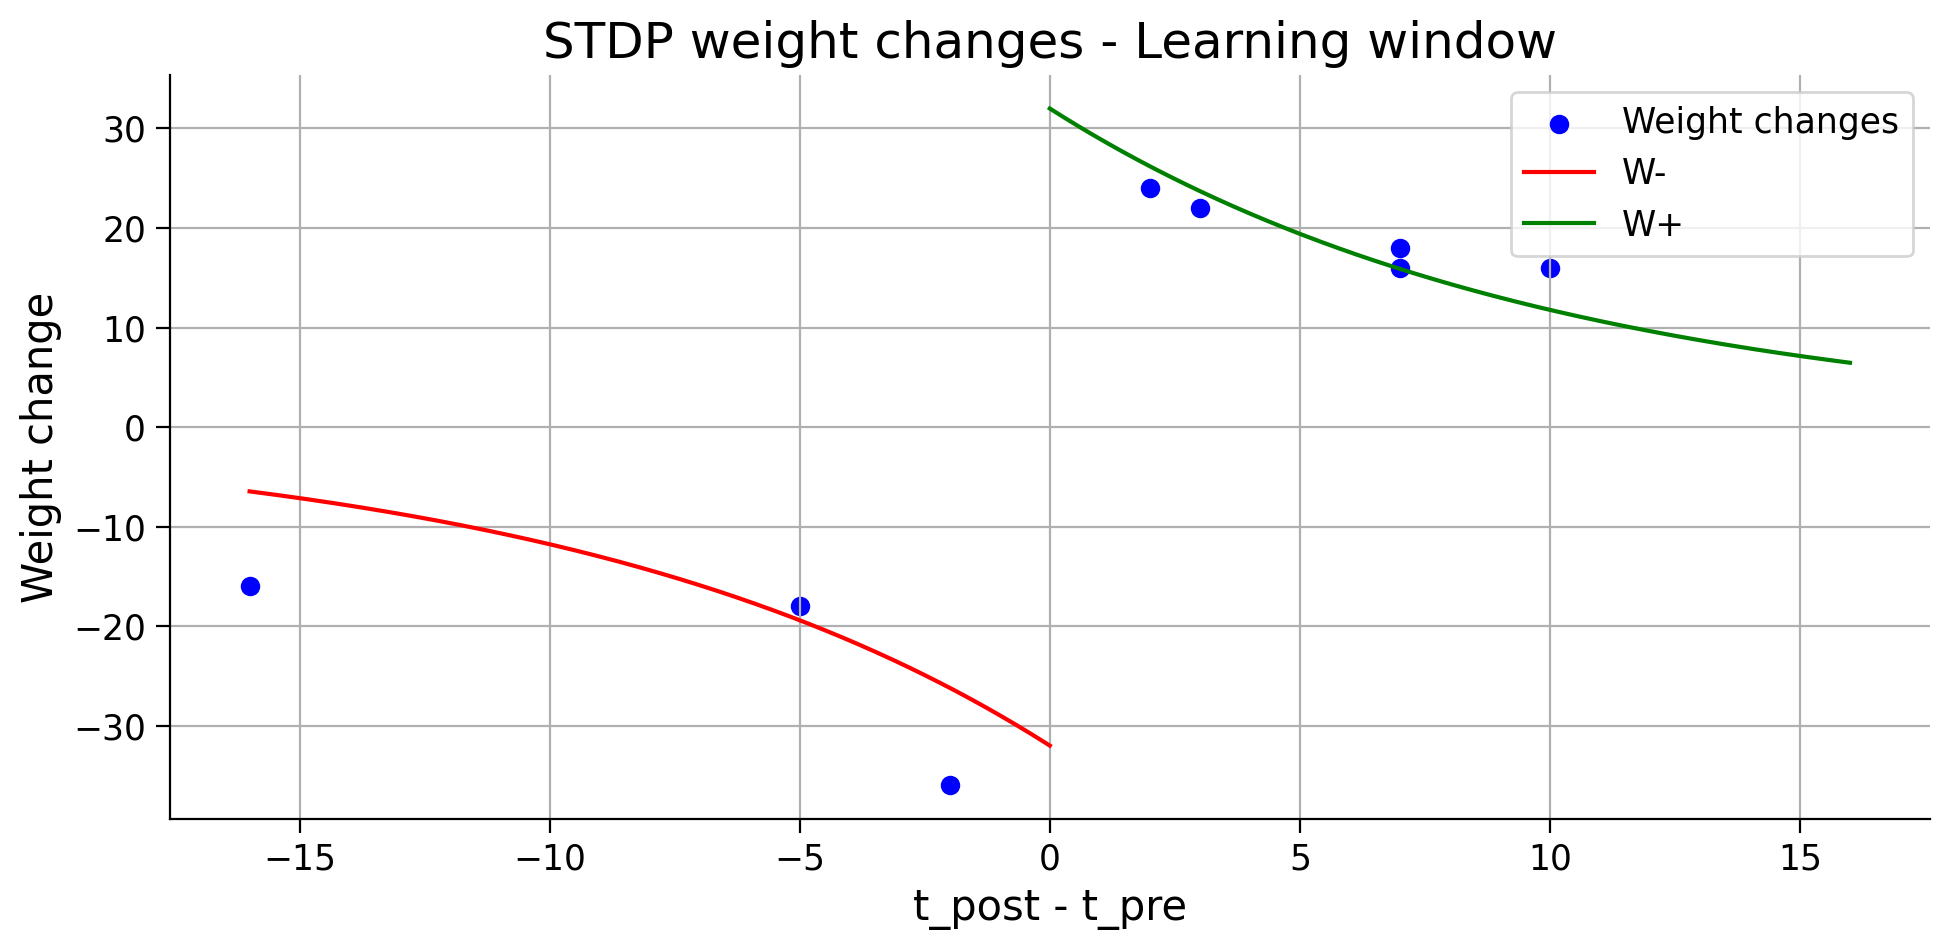

In [40]:
def extract_stdp_weight_changes(time, spikes_pre, spikes_post, wgt):
    # Compute the weight changes for every weight change event
    w_diff = np.zeros(wgt.shape)
    w_diff[1:] = np.diff(wgt)

    w_diff_non_zero = np.where(w_diff != 0)
    dw = w_diff[w_diff_non_zero].tolist()

    # Find the absolute time of every weight change event
    time = np.array(time)
    t_non_zero = time[w_diff_non_zero]

    # Compute the difference between post and pre synaptic spike time for every weight change event
    spikes_pre = np.array(spikes_pre)
    spikes_post = np.array(spikes_post)
    dt = []
    for i in range(0, len(dw)):
        time_stamp = t_non_zero[i]
        t_post = (spikes_post[np.where(spikes_post <= time_stamp)])[-1]
        t_pre = (spikes_pre[np.where(spikes_pre <= time_stamp)])[-1]
        dt.append(t_post-t_pre)

    return np.array(dt), np.array(dw)

def plot_stdp(time, spikes_pre, spikes_post, wgt,
              on_pre_stdp, y1_impulse, y1_tau,
              on_post_stdp, x1_impulse, x1_tau):
    # Derive weight changes as a function of time differences
    diff_t, diff_w = extract_stdp_weight_changes(time, spikes_pre, spikes_post, wgt)

    # Derive learning rule coefficients
    on_pre_stdp = eval(str(on_pre_stdp).replace("^", "**"))
    a_neg = on_pre_stdp * y1_impulse
    on_post_stdp = eval(str(on_post_stdp).replace("^", "**"))
    a_pos = on_post_stdp * x1_impulse

    # Derive x-axis limit (absolute value)
    max_abs_dt = np.maximum(np.abs(np.max(diff_t)), np.abs(np.min(diff_t)))

    # Derive x-axis for learning window computation (negative part)
    x_neg = np.linspace(-max_abs_dt, 0, 1000)
    # Derive learning window (negative part)
    w_neg = a_neg * np.exp(x_neg / y1_tau)

    # Derive x-axis for learning window computation (positive part)
    x_pos = np.linspace(0, max_abs_dt, 1000)
    # Derive learning window (positive part)
    w_pos = a_pos * np.exp(- x_pos / x1_tau)

    plt.figure(figsize=(10, 5))

    plt.scatter(diff_t, diff_w, label="Weight changes", color="b")

    plt.plot(x_neg, w_neg, label="W-", color="r")
    plt.plot(x_pos, w_pos, label="W+", color="g")

    plt.title("STDP weight changes - Learning window")
    plt.xlabel('t_post - t_pre')
    plt.ylabel('Weight change')
    plt.legend()
    plt.grid()

    plt.show()

# Plot STDP window
plot_stdp(time, np.where(pre_spikes[:, 0]), np.where(post_spikes[:, 0]), weights[:, 0],
          on_pre_stdp, stdp.y1_impulse, stdp.x1_tau,
          on_post_stdp, stdp.x1_impulse, stdp.y1_tau)